# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
env.brain_names

['ReacherBrain']

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


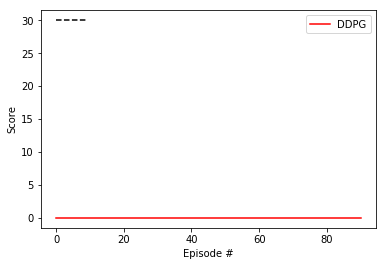

In [41]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque
import numpy as np
from datetime import datetime
from utils import utils
from unity_env_decorator import UnityEnvDecorator
from agents.ddpg_agent import DDPGAgent
from utils.utils import ScoreParcels

version='DDPG'
dir_logs='./logs/'
dir_checkpoints='./checkpoints/'

agent = DDPGAgent(state_size=33, action_size=4, random_seed=0)

def DDPG(env, agent, n_episode=1000, max_t=300, print_every=100, size_window=100):
    # Record accumulated reward for every episode
    scores_deque = deque(maxlen=size_window)
    scores = []
    
    # Decorator of unity environmet
    envDecorator = UnityEnvDecorator(env)
    
    # Declare time stamp for total execution time
    time_total_start = datetime.now()
    
    for i_episode in range(1, n_episode+1):
        state = envDecorator.reset()
        agent.reset()
        score = 0.0
        time_episode_start = datetime.now()
        for _ in range(max_t):
            
            action = agent.act(state)

            next_state, reward, done, _ = envDecorator.step(action)

            agent.step(state, action, reward, next_state, done)

            state = next_state
            
            score += reward
            if done:
                break

        scores_deque.append(score)
        scores.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tTime from episode 1: {}\r'.format(i_episode,
                                                                        np.mean(scores_deque),
                                                                        datetime.now() - time_total_start),
                                                                         end='')
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tAverage Time={}'.format(i_episode,
                                                                            np.mean(scores_deque),
                                                                            datetime.now() - time_episode_start))
            
    return scores


scores = DDPG(env, agent, n_episode=10)

utils.save_logs(scores, dir_logs, version)
path_score = utils.log_path_name(dir_logs, version)

score_parcels = [ScoreParcels('DDPG', path_score, 'r')]
utils.plot_scores(score_parcels, size_window=100)


### Save Models and Log

In [26]:

# save models in the agent. (Agent needs to return dict with model-name pair)
utils.save_agent(agent.model_dicts(), dir_checkpoints, version)